In [1]:
import pychemauth
import pickle

from pychemauth.classifier.cnn import CNNFactory

2024-10-23 10:31:39.146347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

Compiler    : GCC 12.2.0
OS          : Linux
Release     : 6.8.0-47-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 40
Architecture: 64bit

watermark : 2.4.3
pychemauth: 0.0.0b4



# Make Dataset

In [4]:
image_size = (2631, 2631, 1)
n_classes = 10
    
build_from_scratch = False

if build_from_scratch:
    # Build the dataset locally from scratch
    from pychemauth.datasets import make_pgaa_images
    from pyts.image import GramianAngularField
    
    res = make_pgaa_images(
        transformer=GramianAngularField(method='difference'), 
        exclude_classes=['Carbon Powder', 'Phosphate Rock', 'Zircaloy'], 
        directory='./2d-dataset', 
        overwrite=False, 
        fmt='npy', 
        valid_range=(0, image_size[0]), 
        renormalize=True,
        test_size=0.2,
        random_state=42
    )
    
    loader = pychemauth.utils.NNTools.build_loader('./2d-dataset/train/', batch_size=30, shuffle=False)
else:
    # Load dataset from HuggingFace
    from pychemauth.utils import NNTools
    from datasets import load_dataset
    
    dataset_fnames = load_dataset(
      "mahynski/pgaa-sample-gadf-images", 
      split="train",
      token="hf_*", # Enter your own token here
      trust_remote_code=True, # This is important to include
      name='filenames' # This is the default
    )

    loader = NNTools.XLoader(
        x_files = [entry['filename'] for entry in dataset_fnames],
        y = [entry['label'] for entry in dataset_fnames],
        batch_size=30,
        exclude=[10, 11, 12], # -> ['Carbon Powder', 'Phosphate Rock', 'Zircaloy']
        shuffle=False
    )

Using the latest cached version of the module from /home/nam4/.cache/huggingface/modules/datasets_modules/datasets/mahynski--pgaa-sample-gadf-images/400aec67cd0d40bf05365b805511e64620c2fc8132651d6a983682735c03897d (last modified on Tue Oct 22 19:29:42 2024) since it couldn't be found locally at mahynski/pgaa-sample-gadf-images, or remotely on the Hugging Face Hub.


# Model 1

In [5]:
cnn_builder = CNNFactory(
    name='mobilenetv3small',
    input_size=image_size,
    n_classes=n_classes,
    pixel_range=(-1,1),
    cam=True,
    dropout=0.2
) 

In [6]:
cnn_builder.build().summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2631, 2631, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, 2631, 2631, 3)     3         
                                                                 
 rescaling_1 (Rescaling)     (None, 2631, 2631, 3)     0         
                                                                 
 MobilenetV3small (Function  (None, 83, 83, 576)       939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 576)               0     

In [7]:
finder = pychemauth.utils.NNTools.find_learning_rate(
    cnn_builder.build(),
    loader,
    start_lr=1.0e-5,
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


1/1 [==============================] - 2s 2s/step
Epoch 1/13


2024-10-22 20:15:47.201483: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2491977960 exceeds 10% of free system memory.
2024-10-22 20:15:47.963075: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3325163520 exceeds 10% of free system memory.
2024-10-22 20:15:48.425983: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3325163520 exceeds 10% of free system memory.
2024-10-22 20:15:48.426019: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3325163520 exceeds 10% of free system memory.
2024-10-22 20:15:49.601378: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3330218880 exceeds 10% of free system memory.


9/9 [==============================] - 132s 14s/step - loss: 2.9314 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 2/13
9/9 [==============================] - 130s 14s/step - loss: 2.9028 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 3/13
9/9 [==============================] - 130s 14s/step - loss: 2.7915 - accuracy: 0.1000 - sparse_categorical_accuracy: 0.1000
Epoch 4/13
9/9 [==============================] - 132s 16s/step - loss: 2.5608 - accuracy: 0.1089 - sparse_categorical_accuracy: 0.1089
Epoch 5/13
9/9 [==============================] - 132s 14s/step - loss: 2.3193 - accuracy: 0.1474 - sparse_categorical_accuracy: 0.1474
Epoch 6/13
9/9 [==============================] - 130s 14s/step - loss: 2.0694 - accuracy: 0.2985 - sparse_categorical_accuracy: 0.2985
Epoch 7/13
9/9 [==============================] - 130s 14s/step - loss: 1.4984 - accuracy: 0.4754 - sparse_categorical_accuracy: 0.4754
Epoch 8/13
9/9 [==============================] - 131s 14s/

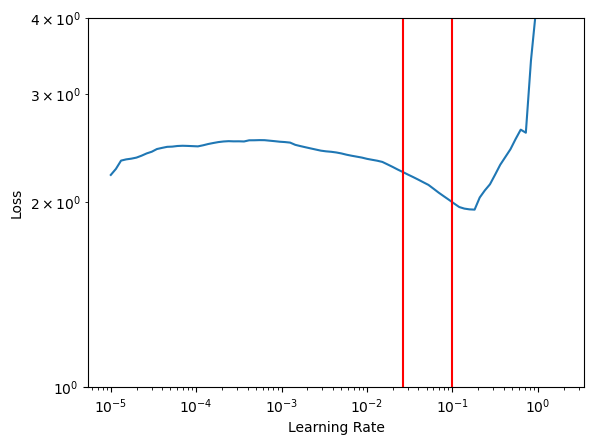

In [10]:
frac = 0.6

ax = finder.plot()
ax.set_yscale('log')
ax.set_ylim(1,4)
for l_ in finder.estimate_clr(frac=frac, skip=0):
    ax.axvline(l_, color='red')

In [11]:
# pickle.dump(finder, open('model1_lrf.pkl', 'wb'), protocol=4)

# Model 2

In [9]:
cnn_builder = CNNFactory(
    name='nasnetmobile',
    input_size=image_size,
    n_classes=n_classes,
    pixel_range=(-1,1),
    cam=True,
    dropout=0.2
) 

In [10]:
cnn_builder.build().summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 2631, 2631, 1)]   0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2631, 2631, 3)     3         
                                                                 
 rescaling_4 (Rescaling)     (None, 2631, 2631, 3)     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 2631, 2631, 3)     0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 2631, 2631, 3)     0         
 da)                                                             
                                                                 
 NASNet (Functional)         (None, 83, 83, 1056)      4269

In [11]:
finder = pychemauth.utils.NNTools.find_learning_rate(
    cnn_builder.build(),
    loader,
    start_lr=1.0e-5,
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


1/1 [==============================] - 5s 5s/step
Epoch 1/13
9/9 [==============================] - 411s 44s/step - loss: 2.6115 - accuracy: 0.0931 - sparse_categorical_accuracy: 0.0931
Epoch 2/13
9/9 [==============================] - 399s 44s/step - loss: 2.5857 - accuracy: 0.0708 - sparse_categorical_accuracy: 0.0708
Epoch 3/13
9/9 [==============================] - 396s 43s/step - loss: 2.5421 - accuracy: 0.0738 - sparse_categorical_accuracy: 0.0738
Epoch 4/13
9/9 [==============================] - 396s 49s/step - loss: 2.3682 - accuracy: 0.0851 - sparse_categorical_accuracy: 0.0851
Epoch 5/13
9/9 [==============================] - 397s 43s/step - loss: 2.2530 - accuracy: 0.1733 - sparse_categorical_accuracy: 0.1733
Epoch 6/13
9/9 [==============================] - 399s 44s/step - loss: 1.6911 - accuracy: 0.4451 - sparse_categorical_accuracy: 0.4451
Epoch 7/13
9/9 [==============================] - 396s 43s/step - loss: 1.0268 - accuracy: 0.6830 - sparse_categorical_accuracy: 0.683

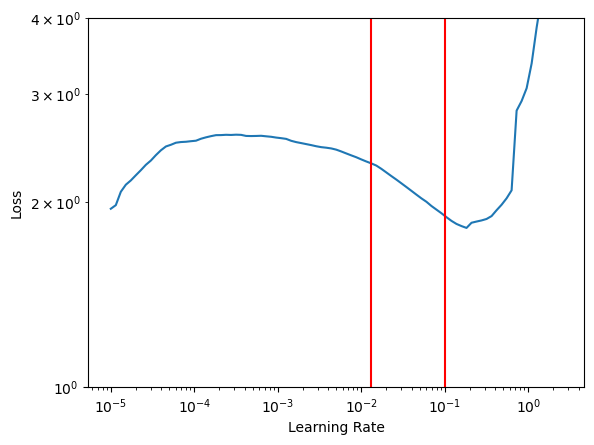

In [12]:
frac = 0.75

ax = finder.plot()
ax.set_yscale('log')
ax.set_ylim(1,4)
for l_ in finder.estimate_clr(frac=frac, skip=5):
    ax.axvline(l_, color='red')

In [15]:
# pickle.dump(finder, open('model2_lrf.pkl', 'wb'), protocol=4)

# Model 3 

In [13]:
cnn_builder = CNNFactory(
    name='inceptionv3',
    input_size=image_size,
    n_classes=n_classes,
    pixel_range=(-1,1),
    cam=True,
    dropout=0.2
) 

In [14]:
cnn_builder.build().summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 2631, 2631, 1)]   0         
                                                                 
 conv2d_98 (Conv2D)          (None, 2631, 2631, 3)     3         
                                                                 
 rescaling_6 (Rescaling)     (None, 2631, 2631, 3)     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 2631, 2631, 3)     0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 2631, 2631, 3)     0         
 mbda)                                                           
                                                                 
 inception_v3 (Functional)   (None, 80, 80, 2048)      2180

In [15]:
finder = pychemauth.utils.NNTools.find_learning_rate(
    cnn_builder.build(),
    loader,
    start_lr=1.0e-5,
)

Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]
Iterating through all batches to summarize, be patient...: 0it [00:00, ?it/s]


1/1 [==============================] - 3s 3s/step
Epoch 1/13
9/9 [==============================] - 413s 45s/step - loss: 2.3540 - accuracy: 0.0539 - sparse_categorical_accuracy: 0.0539
Epoch 2/13
9/9 [==============================] - 410s 45s/step - loss: 2.3605 - accuracy: 0.0338 - sparse_categorical_accuracy: 0.0338
Epoch 3/13
9/9 [==============================] - 410s 45s/step - loss: 2.3225 - accuracy: 0.0755 - sparse_categorical_accuracy: 0.0755
Epoch 4/13
9/9 [==============================] - 409s 50s/step - loss: 2.3031 - accuracy: 0.0585 - sparse_categorical_accuracy: 0.0585
Epoch 5/13
9/9 [==============================] - 408s 45s/step - loss: 2.2032 - accuracy: 0.1127 - sparse_categorical_accuracy: 0.1127
Epoch 6/13
9/9 [==============================] - 408s 45s/step - loss: 1.7911 - accuracy: 0.3586 - sparse_categorical_accuracy: 0.3586
Epoch 7/13
9/9 [==============================] - 409s 45s/step - loss: 1.1397 - accuracy: 0.7083 - sparse_categorical_accuracy: 0.708

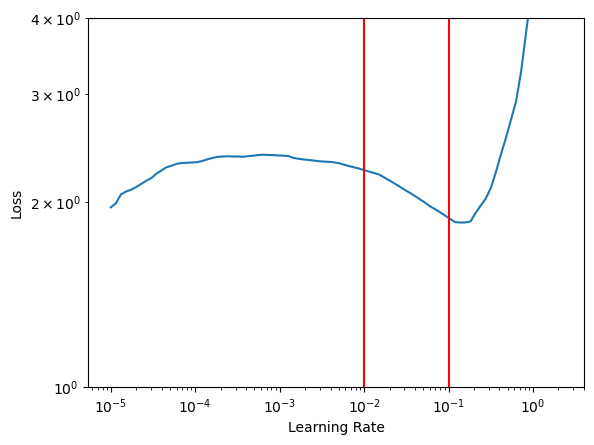

In [16]:
frac = 0.75

ax = finder.plot()
ax.set_yscale('log')
ax.set_ylim(1,4)
for l_ in finder.estimate_clr(frac=frac, skip=20):
    ax.axvline(l_, color='red')

In [19]:
# pickle.dump(finder, open('model3_lrf.pkl', 'wb'), protocol=4)